In [373]:
import pandas as pd
import numpy as np
import torch
import time
import math
import random
import matplotlib.pyplot as plt
import torch.nn as nn  #allthe nn modules
import torch.optim as optim #optimization algorithms Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
import torchvision 
import torchvision.transforms as transforms
df=pd.read_csv("dataSets/titanic.csv")

In [67]:
del df["PassengerId"]
del df["Name"]
del df["Ticket"]
del df["Cabin"]
df['Sex']=df['Sex'].replace(to_replace='male',value='1')
df['Sex']=df['Sex'].replace(to_replace='female',value='0')
df['Embarked']=df['Embarked'].replace(to_replace='S',value='0')
df['Embarked']=df['Embarked'].replace(to_replace='C',value='1')
df['Embarked']=df['Embarked'].replace(to_replace='Q',value='2')
df=df.dropna()
y=df['Survived']
y_temp=df['Survived']
X=df.drop(['Survived'],axis=1)
#y_temp=y_temp.reset_index(drop=True)
y=y.reset_index(drop=True)
X=X.reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 25)  #same as DT
sc_X=StandardScaler()
X_train=sc_X.fit_transform(X_train)
X_test=sc_X.fit_transform(X_test)
X_train=torch.tensor(X_train)
y_train=torch.tensor(y_train.astype(float).values)  #this is still a data frame
X_test=torch.tensor(X_test)
y_test=torch.tensor(y_test.astype(float).values)
y_train=torch.reshape(y_train,(X_train.size()[0],1))
y_test=torch.reshape(y_test,(X_test.size()[0],1))

n_input, n_hidden, n_out, batch_size, learning_rate = 7, 5, 1, X_train.size()[0], 0.01

In [383]:
def acc_func(y_pred,y_train):
    correct=0
    total=0
    TP=0
    FP=0
    TN=0
    FN=0
    for i in range(y_pred.size()[0]):
        m=y_pred[i].float()
        t=y_train[i].item()
        if m<.5:
            rounded=0
        else:
            rounded=1
        if t>0 and (rounded-t)==0:
            TP=TP+1
        if t==0 and (rounded-t)==0:
            TN=TN+1
        if t>0 and (rounded-t)!=0:
            FN=FN+1
        if t==0 and (rounded-t)!=0:
            FP=FP+1    
        total+=1    
    accuracy=(TP+TN)/(TP+TN+FN+FP)
    return accuracy

model = nn.Sequential(  #Sequential lives inside the nueral network class
                      nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid())

def RHC_proposed(weight0, weight2,T):
    weight_list0=weight0.tolist()
    weight_list2=weight2.tolist()
    cov1=T*np.diag(np.ones(7))
    cov2=T*np.diag(np.ones(5))
    prop1=[]
    prop2=[]
    for i in range(5):
        mn=weight_list0[i]
        temp=np.random.multivariate_normal(mn,cov1)
        prop1.append(temp.tolist())
    temp=np.random.multivariate_normal(weight_list2[0],cov2).tolist()  
    prop2.append(temp)
    prop1=torch.tensor(prop1)
    prop2=torch.tensor(prop2)
    return prop1, prop2

In [384]:
losses=[]
losses_test=[]
accuracy=[]
accuracy_test=[]
T=.001

tic = time.perf_counter()
for i in range(1000):
    y_pred=model(X_train.float())
    y_pred_test=model(X_test.float())
    loss=sum((y_pred-y_train)**2)/y_train.shape[0]
    
    loss_test=sum((y_pred_test-y_test)**2)/y_test.shape[0]
    acc=acc_func(y_pred,y_train)
    acc_test=acc_func(y_pred_test,y_test)
    accuracy.append(acc)
    accuracy_test.append(acc_test)
    losses.append(loss.item())
    losses_test.append(loss_test.item())
    
    one=loss.tolist()    
    wght0=(model[0].weight)
    wght2=(model[2].weight)
    prop0,prop2=RHC_proposed(wght0,wght2,T)
    model[0].weight=nn.Parameter(prop0)
    model[2].weight=nn.Parameter(prop2)
    y_pred=model(X_train.float())
    y_pred_test=model(X_test.float())
    loss=sum((y_pred-y_train)**2)/y_train.shape[0]
    two=loss.tolist()
    diff=one[0]-two[0]
    if diff<0:
        model[0].weight=nn.Parameter(wght0)
        model[2].weight=nn.Parameter(wght2)
    
    
toc = time.perf_counter()
print(f"Producing best fit model for NN {toc - tic:0.4f} seconds")


Producing best fit model for NN 14.8836 seconds


In [385]:
for i in range(len(losses)-1):
    if losses[i+1]-losses[i]>0:
       print(losses[i+1]-losses[i])           

In [386]:
#train
correct=0
total=0
TP=0
FP=0
TN=0
FN=0
for i in range(X_train.size()[0]):
    m=model(X_train[i].float())[0].item()
    t=y_train[i].item()
    if m<.5:
        rounded=0
    else:
        rounded=1
    if t>0 and (rounded-t)==0:
        TP=TP+1
    if t==0 and (rounded-t)==0:
        TN=TN+1
    if t>0 and (rounded-t)!=0:
        FN=FN+1
    if t==0 and (rounded-t)!=0:
        FP=FP+1    
    total+=1    
    
print("accuracy: ",(TP+TN)/(TP+TN+FN+FP))
recall=TP/(FN+TP)
prec=TP/(FP+TP)
print("f1_score: ",2*(recall*prec)/(recall+prec))

accuracy:  0.848314606741573
f1_score:  0.7990074441687345


In [387]:
#test
correct=0
total=0
TP=0
FP=0
TN=0
FN=0
for i in range(X_test.size()[0]):
    m=model(X_test[i].float())[0].item()
    t=y_test[i].item()
    if m<.5:
        rounded=0
    else:
        rounded=1
    if t>0 and (rounded-t)==0:
        TP=TP+1
    if t==0 and (rounded-t)==0:
        TN=TN+1
    if t>0 and (rounded-t)!=0:
        FN=FN+1
    if t==0 and (rounded-t)!=0:
        FP=FP+1    
    total+=1    
    
print("accuracy: ",(TP+TN)/(TP+TN+FN+FP))
recall=TP/(FN+TP)
prec=TP/(FP+TP)
print("f1_score: ",2*(recall*prec)/(recall+prec))

accuracy:  0.8089887640449438
f1_score:  0.746268656716418


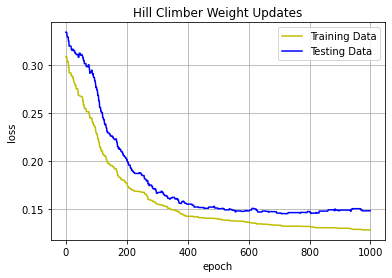

In [179]:

plt.plot(losses, color="y",
        label="Training Data")
plt.plot(losses_test, color="b",
        label="Testing Data")
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Hill Climber Weight Updates")
plt.legend(loc="best")
plt.show()    


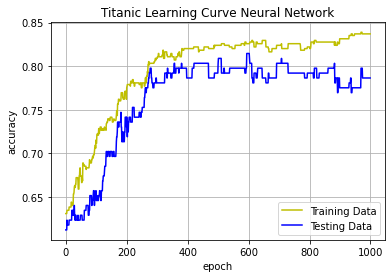

In [180]:
plt.plot(accuracy, color="y",
        label="Training Data")
plt.plot(accuracy_test, color="b",
        label="Testing Data")

plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title("Titanic Learning Curve Neural Network")
plt.legend(loc="best")
plt.show()   

In [377]:
#SA
def acc_func(y_pred,y_train):
    correct=0
    total=0
    TP=0
    FP=0
    TN=0
    FN=0
    for i in range(y_pred.size()[0]):
        m=y_pred[i].float()
        t=y_train[i].item()
        if m<.5:
            rounded=0
        else:
            rounded=1
        if t>0 and (rounded-t)==0:
            TP=TP+1
        if t==0 and (rounded-t)==0:
            TN=TN+1
        if t>0 and (rounded-t)!=0:
            FN=FN+1
        if t==0 and (rounded-t)!=0:
            FP=FP+1    
        total+=1    
    accuracy=(TP+TN)/(TP+TN+FN+FP)
    return accuracy

model = nn.Sequential(  #Sequential lives inside the nueral network class
                      nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid())

def proposed(weight0, weight2,sig):
    weight_list0=weight0.tolist()
    weight_list2=weight2.tolist()
    cov1=sig*np.diag(np.ones(7))
    cov2=sig*np.diag(np.ones(5))
    prop1=[]
    prop2=[]
    for i in range(5):
        mn=weight_list0[i]
        temp=np.random.multivariate_normal(mn,cov1)
        prop1.append(temp.tolist())
    temp=np.random.multivariate_normal(weight_list2[0],cov2).tolist()  
    prop2.append(temp)
    prop1=torch.tensor(prop1)
    prop2=torch.tensor(prop2)
    return prop1, prop2

In [378]:
#SA
losses=[]
losses_test=[]
accuracy=[]
accuracy_test=[]
iterations=10000
sig=.001
T=.01

tic = time.perf_counter()
for i in range(iterations):
    y_pred=model(X_train.float())
    y_pred_test=model(X_test.float())
    loss=sum((y_pred-y_train)**2)/y_train.shape[0]
    
    loss_test=sum((y_pred_test-y_test)**2)/y_test.shape[0]
    acc=acc_func(y_pred,y_train)
    acc_test=acc_func(y_pred_test,y_test)
    accuracy.append(acc)
    accuracy_test.append(acc_test)
    losses.append(loss.item())
    losses_test.append(loss_test.item())
    
    one=loss.tolist()    
    wght0=(model[0].weight)
    wght2=(model[2].weight)
    prop0,prop2=proposed(wght0,wght2,sig)
    model[0].weight=nn.Parameter(prop0)
    model[2].weight=nn.Parameter(prop2)
    y_pred=model(X_train.float())
    y_pred_test=model(X_test.float())
    loss=sum((y_pred-y_train)**2)/y_train.shape[0]
    two=loss.tolist()
    diff=one[0]-two[0]
    if diff<0:
        model[0].weight=nn.Parameter(wght0)
        model[2].weight=nn.Parameter(wght2)
    elif math.log(np.random.rand())*T>diff:
        model[0].weight=nn.Parameter(wght0)
        model[2].weight=nn.Parameter(wght2)
    T=(iterations-i)/iterations
    
toc = time.perf_counter()
print(f"Producing best fit model for NN {toc - tic:0.4f} seconds")


Producing best fit model for NN 146.4857 seconds


In [379]:
#train
correct=0
total=0
TP=0
FP=0
TN=0
FN=0
for i in range(X_train.size()[0]):
    m=model(X_train[i].float())[0].item()
    t=y_train[i].item()
    if m<.5:
        rounded=0
    else:
        rounded=1
    if t>0 and (rounded-t)==0:
        TP=TP+1
    if t==0 and (rounded-t)==0:
        TN=TN+1
    if t>0 and (rounded-t)!=0:
        FN=FN+1
    if t==0 and (rounded-t)!=0:
        FP=FP+1    
    total+=1    
    
print("accuracy: ",(TP+TN)/(TP+TN+FN+FP))
recall=TP/(FN+TP)
prec=TP/(FP+TP)
print("f1_score: ",2*(recall*prec)/(recall+prec))

accuracy:  0.8520599250936329
f1_score:  0.8010075566750628


In [380]:
#test
correct=0
total=0
TP=0
FP=0
TN=0
FN=0
for i in range(X_test.size()[0]):
    m=model(X_test[i].float())[0].item()
    t=y_test[i].item()
    if m<.5:
        rounded=0
    else:
        rounded=1
    if t>0 and (rounded-t)==0:
        TP=TP+1
    if t==0 and (rounded-t)==0:
        TN=TN+1
    if t>0 and (rounded-t)!=0:
        FN=FN+1
    if t==0 and (rounded-t)!=0:
        FP=FP+1    
    total+=1    
    
print("accuracy: ",(TP+TN)/(TP+TN+FN+FP))
recall=TP/(FN+TP)
prec=TP/(FP+TP)
print("f1_score: ",2*(recall*prec)/(recall+prec))

accuracy:  0.8146067415730337
f1_score:  0.7518796992481203


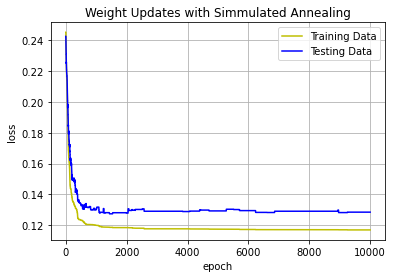

In [381]:
plt.plot(losses, color="y",
        label="Training Data")
plt.plot(losses_test, color="b",
        label="Testing Data")
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Weight Updates with Simmulated Annealing")
plt.legend(loc="best")
plt.show()    

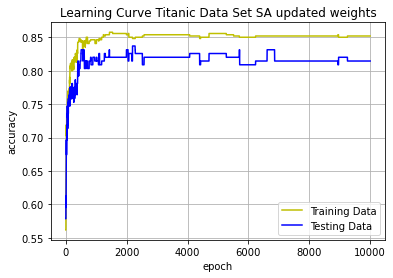

In [382]:
plt.plot(accuracy, color="y",
        label="Training Data")
plt.plot(accuracy_test, color="b",
        label="Testing Data")

plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title("Learning Curve Titanic Data Set SA updated weights")
plt.legend(loc="best")
plt.show()   

In [359]:
#GA

def acc_func(y_pred,y_train):
    correct=0
    total=0
    TP=0
    FP=0
    TN=0
    FN=0
    for i in range(y_pred.size()[0]):
        m=y_pred[i].float()
        t=y_train[i].item()
        if m<.5:
            rounded=0
        else:
            rounded=1
        if t>0 and (rounded-t)==0:
            TP=TP+1
        if t==0 and (rounded-t)==0:
            TN=TN+1
        if t>0 and (rounded-t)!=0:
            FN=FN+1
        if t==0 and (rounded-t)!=0:
            FP=FP+1    
        total+=1    
    accuracy=(TP+TN)/(TP+TN+FN+FP)
    return accuracy


def init_pop(weight0,weight2,pop_size,sig):
    pop_weight_array=[]
    weight_list0=weight0.tolist()
    weight_list2=weight2.tolist()
    cov1=sig*np.diag(np.ones(7))
    cov2=sig*np.diag(np.ones(5))
    for j in range(pop_size):
        prop1=[]
        prop2=[]
        for i in range(5):
            mn=weight_list0[i]
            temp=np.random.multivariate_normal(mn,cov1)
            prop1.append(temp.tolist())
        temp=np.random.multivariate_normal(weight_list2[0],cov2).tolist()  
        prop2.append(temp)
        prop1=torch.tensor(prop1)
        prop2=torch.tensor(prop2)
        pop_weight_array.append([prop1,prop2])
    return pop_weight_array    

def rack_n_stack(pop,p_keep):    
    n = len(pop)
    keep=math.ceil(n*p_keep)
    next_gen=[]
    score_array=[]
    y_pred_test=model(X_test.float())
    for i in range(len(pop)):
        a1=pop[i][0].tolist()
        b1=pop[i][1].tolist()
        a1=torch.tensor(a1)
        b1=torch.tensor(b1)
        model[0].weight=nn.Parameter(a1)
        model[2].weight=nn.Parameter(b1)
        y_pred=model(X_train.float())
        loss=sum((y_pred-y_train)**2)/y_train.shape[0]
        score_array.append(loss)
    for i in range(n):
        sort_comp = True
        for j in range(n - i - 1):
            if score_array[j] > score_array[j + 1]:
                score_array[j+1], score_array[j] = score_array[j], score_array[j+1]
                pop[j+1], pop[j] = pop[j], pop[j+1]
                sort_comp = False
        if sort_comp:
            break
    next_gen=pop[:keep]        
    return next_gen
        
def cross_mutate(next_gen,tot,mutation_rate):
    n=len(next_gen)
    num_children=tot-n
    zero_pos=list(range(5))
    pop_coords=list(range(len(res)))
    
    for j in range(num_children):
        parent_coords=random.sample(pop_coords, 2)
        dad=next_gen[parent_coords[0]]
        mom=next_gen[parent_coords[1]]
        dad_genes=random.randint(0, 4)
        mom_genes=4-dad_genes
        dad_coord=np.random.choice(zero_pos,dad_genes)
        mom_coord=list(set(zero_pos)-set(dad_coord))
        top=np.zeros((5,7))
        bottom=np.zeros(5)
        t=torch.tensor(top)
        b=torch.tensor(bottom)
        child=[t,b]
      
        for i in range(len(dad_coord)):
            child[0][dad_coord[i]]=dad[0][dad_coord[i]]
        for i in range(len(mom_coord)):
            child[0][mom_coord[i]]=mom[0][mom_coord[i]]
        if len(dad_coord)>len(mom_coord):
            child[1]=mom[1]#.astype(float64).values
        else:
            child[1]=dad[1]
        if(np.random.uniform()<mutation_rate):  
            mut_pos=random.randint(0,5)
            if mut_pos==5:
                mn=child[1].tolist()
                mn=mn[0]
                cov=.0001*np.diag(np.ones(5))
                temp=np.random.multivariate_normal(mn,cov)
                temp1=torch.tensor(temp)
            else:
                mn=child[0][mut_pos]
                cov=.0001*np.diag(np.ones(7))
                temp=np.random.multivariate_normal(mn,cov)
                temp1=torch.tensor(temp)
            if mut_pos==5:
                child[1][0]=temp1
            else:
                child[0][mut_pos]=temp1
        next_gen.append(child)
    return next_gen
    
    


In [368]:
#GA

model = nn.Sequential(  #Sequential lives inside the nueral network class
                      nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid())

losses=[]
losses_test=[]
accuracy=[]
accuracy_test=[]
iterations=10000
mutation_rate=.1
init_weight0=model[0].weight
init_weight2=model[2].weight
pop_size=5
sig=.001
p_keep=.5


new_pop=init_pop(init_weight0,init_weight2,pop_size,sig) 

for i in range(iterations):
    if i%500==0:
        print(i)
    next_gen=rack_n_stack(new_pop,p_keep)
    #for each in next_gen:
        #print(each)
    whos_num_one=next_gen[0]
    a0=whos_num_one[0].tolist()
    a0=torch.tensor(a0)
    b0=whos_num_one[1].tolist()
    b0=torch.tensor(b0)

    model[0].weight=nn.Parameter(a0)
    model[2].weight=nn.Parameter(b0)
    
    y_pred=model(X_train.float())
    y_pred_test=model(X_test.float())
    loss=sum((y_pred-y_train)**2)/y_train.shape[0]    
    loss_test=sum((y_pred_test-y_test)**2)/y_test.shape[0]
    acc=acc_func(y_pred,y_train)
    acc_test=acc_func(y_pred_test,y_test)
    accuracy.append(acc)
    accuracy_test.append(acc_test)
    losses.append(loss.item())
    losses_test.append(loss_test.item())
    new_pop=cross_mutate(next_gen,pop_size,mutation_rate)
    #print(" ")
    #for each in new_pop:
    #    print(each)


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [370]:

#train
correct=0
total=0
TP=0
FP=0
TN=0
FN=0
for i in range(X_train.size()[0]):
    m=model(X_train[i].float())[0].item()
    t=y_train[i].item()
    if m<.5:
        rounded=0
    else:
        rounded=1
    if t>0 and (rounded-t)==0:
        TP=TP+1
    if t==0 and (rounded-t)==0:
        TN=TN+1
    if t>0 and (rounded-t)!=0:
        FN=FN+1
    if t==0 and (rounded-t)!=0:
        FP=FP+1    
    total+=1    
    
print("accuracy: ",(TP+TN)/(TP+TN+FN+FP))
recall=TP/(FN+TP)
prec=TP/(FP+TP)
print("f1_score: ",2*(recall*prec)/(recall+prec))

accuracy:  0.7808988764044944
f1_score:  0.7536842105263157


In [371]:
#test
correct=0
total=0
TP=0
FP=0
TN=0
FN=0
for i in range(X_test.size()[0]):
    m=model(X_test[i].float())[0].item()
    t=y_test[i].item()
    if m<.5:
        rounded=0
    else:
        rounded=1
    if t>0 and (rounded-t)==0:
        TP=TP+1
    if t==0 and (rounded-t)==0:
        TN=TN+1
    if t>0 and (rounded-t)!=0:
        FN=FN+1
    if t==0 and (rounded-t)!=0:
        FP=FP+1    
    total+=1    
    
print("accuracy: ",(TP+TN)/(TP+TN+FN+FP))
recall=TP/(FN+TP)
prec=TP/(FP+TP)
print("f1_score: ",2*(recall*prec)/(recall+prec))

accuracy:  0.7528089887640449
f1_score:  0.7317073170731707


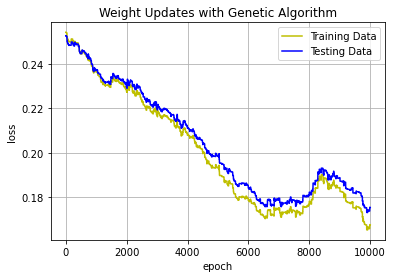

In [374]:
plt.plot(losses, color="y",
        label="Training Data")
plt.plot(losses_test, color="b",
        label="Testing Data")
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Weight Updates with Genetic Algorithm")
plt.legend(loc="best")
plt.show()    

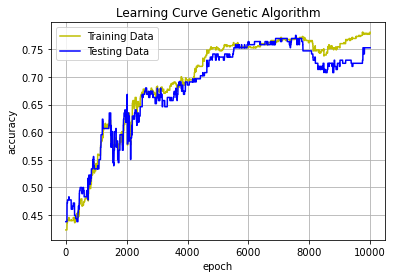

In [376]:
plt.plot(accuracy, color="y",
        label="Training Data")
plt.plot(accuracy_test, color="b",
        label="Testing Data")

plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title("Learning Curve Genetic Algorithm")
plt.legend(loc="best")
plt.show()   

In [389]:
SA=[0.81, 0.75,146.4]
rhc=[.79, .74, 15]
GA=[.75, .73, 735]

print(SA)
print(rhc)
print(GA)

[0.81, 0.75, 146.4]
[0.79, 0.74, 15]
[0.75, 0.73, 735]
